# ROC Curve and the UCI German Credit Data Set.
### Kevin Maher
### <span style="color:blue">Vettejeep365@gmail.com</span>

This is a classification problem. The goal is to predict which loans will be good and which ones will default.  It tends to be difficult to obtain high accuracy, especially since  the problem of predicting loans as good which later default is considered to be a more serious error.  When we did this with tree based models in a graduate course at Regis where we were studying tree-based models, all of us in the class had accuracy issues with this data set.  Here I have used logistic regression.  This has the advantage of reducing the number of failed predictions on predicted good loans.  The class weight parameter of the logistic regression model can be tuned to reduce the number of failed loans from those predicted as good loans; though at the cost of predicting more failed loans that turn out to not default.

Mostly I chose this data set and model because it offers the opportunity to show a Receiver Operator Characteristic (ROC) curve for a model that is only a moderately good predictor.  The ROC curve is a plot of the true positive rate against the false positive rate and the greater the area under the curve the more accurate the predictive model is.

Imports needed for the script. Uses Python 2.7.13, numpy 1.11.3, pandas 0.19.2, sklearn 0.18.1, matplotlib 2.0.0.

In [17]:
%matplotlib inline

import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

Import the data.  The data file is from:

https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

In [18]:
column_names = ['CkgAcct', 'Duration', 'CreditHistory', 'Purpose', 'CreditAmt', 'Savings', 'EmploymentTime',
               'PctIncome', 'PersStatus', 'OtherDebts', 'ResidenceSince', 'Property',
               'AgeYrs', 'OtherLoan', 'Housing', 'NumCredits', 'Job', 'FamSize', 'Telephone',
               'Foriegn', 'LoanGood']

df = pd.read_table('german.data.txt', names=column_names, sep=' ')
print df.head()

  CkgAcct  Duration CreditHistory Purpose  CreditAmt Savings EmploymentTime  \
0     A11         6           A34     A43       1169     A65            A75   
1     A12        48           A32     A43       5951     A61            A73   
2     A14        12           A34     A46       2096     A61            A74   
3     A11        42           A32     A42       7882     A61            A74   
4     A11        24           A33     A40       4870     A61            A73   

   PctIncome PersStatus OtherDebts   ...     Property AgeYrs  OtherLoan  \
0          4        A93       A101   ...         A121     67       A143   
1          2        A92       A101   ...         A121     22       A143   
2          2        A93       A101   ...         A121     49       A143   
3          2        A93       A103   ...         A122     45       A143   
4          3        A93       A101   ...         A124     53       A143   

  Housing NumCredits   Job FamSize  Telephone Foriegn LoanGood  
0    A152

Make binary factors into 1/0.

In [19]:
df['Foriegn'] = df['Foriegn'].eq('A202').mul(1)
df['Telephone'] = df['Telephone'].eq('A192').mul(1)

For multi-level features, make a function to convert to dummy variables.

In [20]:
def get_dummies(source_df, dest_df, col):
    dummies = pd.get_dummies(source_df[col], prefix=col)

    print 'Quantities for %s column' % col
    for col in dummies:
        print '%s: %d' % (col, np.sum(dummies[col]))
    print

    dest_df = dest_df.join(dummies)
    return dest_df

Convert multi-level features to dummy variables, print the quantities for each level. Drop the original features since they have been converted.

In [21]:
ohe_features = ['CkgAcct', 'CreditHistory', 'Purpose', 'Savings', 'EmploymentTime',
                'PersStatus', 'OtherDebts', 'Property', 'OtherLoan', 'Housing', 'Job']

for feature in ohe_features:
    df = get_dummies(df, df, feature)

df.drop(ohe_features, axis=1, inplace=True)

Quantities for CkgAcct column
CkgAcct_A11: 274
CkgAcct_A12: 269
CkgAcct_A13: 63
CkgAcct_A14: 394

Quantities for CreditHistory column
CreditHistory_A30: 40
CreditHistory_A31: 49
CreditHistory_A32: 530
CreditHistory_A33: 88
CreditHistory_A34: 293

Quantities for Purpose column
Purpose_A40: 234
Purpose_A41: 103
Purpose_A410: 12
Purpose_A42: 181
Purpose_A43: 280
Purpose_A44: 12
Purpose_A45: 22
Purpose_A46: 50
Purpose_A48: 9
Purpose_A49: 97

Quantities for Savings column
Savings_A61: 603
Savings_A62: 103
Savings_A63: 63
Savings_A64: 48
Savings_A65: 183

Quantities for EmploymentTime column
EmploymentTime_A71: 62
EmploymentTime_A72: 172
EmploymentTime_A73: 339
EmploymentTime_A74: 174
EmploymentTime_A75: 253

Quantities for PersStatus column
PersStatus_A91: 50
PersStatus_A92: 310
PersStatus_A93: 548
PersStatus_A94: 92

Quantities for OtherDebts column
OtherDebts_A101: 907
OtherDebts_A102: 41
OtherDebts_A103: 52

Quantities for Property column
Property_A121: 282
Property_A122: 232
Property_A1

"Leave one out", n-1 dummy variables fully describe the categorical feature.

In [22]:
drop_dummies = ['CkgAcct_A14', 'CreditHistory_A32', 'Purpose_A43', 'Savings_A61', 'EmploymentTime_A73',
                'PersStatus_A93', 'OtherDebts_A101', 'Property_A123', 'OtherLoan_A143', 'Housing_A152',
                'Job_A173']
df.drop(drop_dummies, axis=1, inplace=True)

Set up for machine learning. 'X' is the data and 'y' is the true classifications from the data set. X_train and y_train are for model training, X_test and y_test are for model testing - proving the model on data unseen during training.

In [23]:
y = df['LoanGood']
X = df.drop('LoanGood', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=245)

Set up the logistic regression.  High accuracy is hard to obtain with this data set.  I tended to get the best balance of accuracy and prediction for predicted good loans not defaulting by setting the class weight for the default class to 2.0.  Higher values for the class weight reduce the number of defaults in predicted good loans but increase the number of predicted bad loans that are good and decrease overall model accuracy.

In [24]:
clf = LogisticRegression(C=1.0, class_weight={1: 1.0, 2: 2.0})
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print 'Model: %.2f%% accurate' % (metrics.accuracy_score(y_test, pred) * 100.0)

Model: 75.67% accurate


Create a function to plot the confusion matrix.  Code from:

http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()
    plt.close()

Plot the confusion matrix.

Confusion matrix, without normalization
[[164  44]
 [ 29  63]]


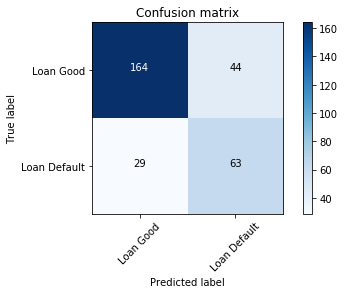

In [26]:
confusion = metrics.confusion_matrix(y_test, pred)
class_names = ['Loan Good', 'Loan Default']
plot_confusion_matrix(confusion, classes=class_names, title='Confusion matrix')

Get the probabilities so that the ROC curve can be plotted.  Also, expand the true value matrix so its size matches the probabilities matrix.  the SKLearn function label binarize needs to be fooled into expanding by adding a dummy class, since for binary problems like this one it produces a matrix with one column.  So, a dummy column is added then sliced off.  See the Scikit Learn documentation for "label_binarize".

In [27]:
pred_proba = clf.predict_proba(X_test)
y_test_expanded = label_binarize(y_test, classes=[1, 2, 3])[:, 0:2]

Compute ROC curve parameters. ROC code from:

http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [28]:
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_expanded[:, i], pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_expanded.ravel(), pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Plot the ROC curve.  The area under the curve is not bad at 0.815, but a bank would probably want much better predictions of loans that will eventually default.  The data in this data set is likely to be inadequate for that, and either more data, or more data features are needed. 

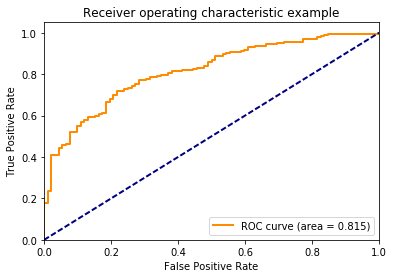

In [30]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Citation: Statlog (German Credit Data) Data Set (1994). UCI Machine Learning Repository. Retrieved from:  

https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29